In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import tkinter as tk
from tkinter import messagebox

In [3]:
# Step 1: Load Dataset

data = pd.read_csv('/content/disasters.csv')


In [4]:
# Display dataset overview
print("Dataset Overview:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Entity  803 non-null    object
 1   Year    803 non-null    int64 
 2   Deaths  803 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 18.9+ KB
None

First 5 rows:
                  Entity  Year   Deaths
0  All natural disasters  1900  1267360
1  All natural disasters  1901   200018
2  All natural disasters  1902    46037
3  All natural disasters  1903     6506
4  All natural disasters  1905    22758


In [5]:
# Step 2: Data Analysis
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values per Column:")
print(missing_values)


Missing Values per Column:
Entity    0
Year      0
Deaths    0
dtype: int64


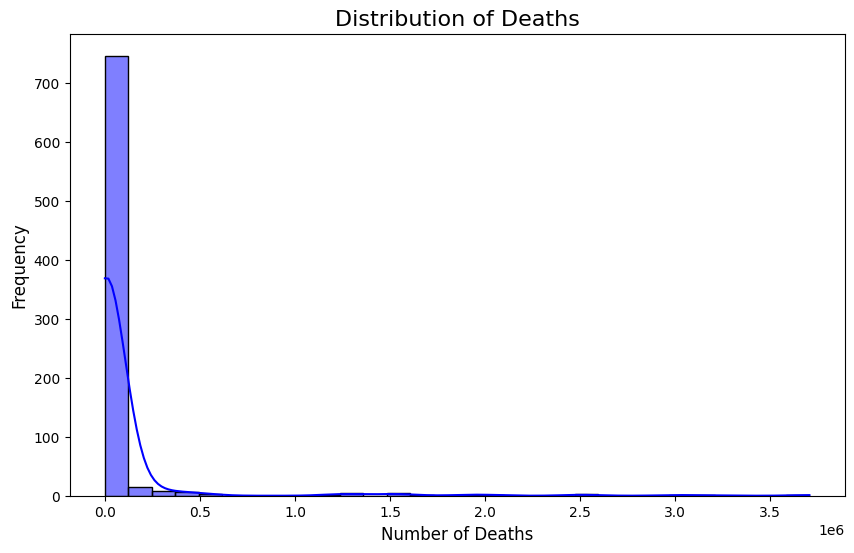

In [6]:
# Distribution of Deaths
plt.figure(figsize=(10, 6))
sns.histplot(data['Deaths'], kde=True, bins=30, color='blue')
plt.title("Distribution of Deaths", fontsize=16)
plt.xlabel("Number of Deaths", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

<ipython-input-7-5c0d2aba3288>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data['Entity'], order=data['Entity'].value_counts().index, palette="viridis")


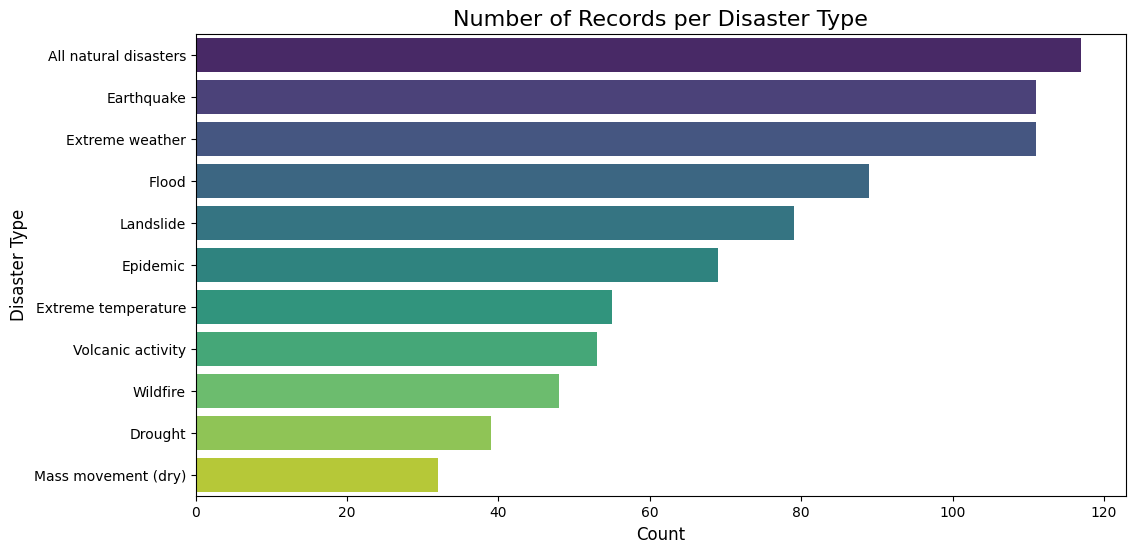

In [7]:
# Number of records per disaster type
plt.figure(figsize=(12, 6))
sns.countplot(y=data['Entity'], order=data['Entity'].value_counts().index, palette="viridis")
plt.title("Number of Records per Disaster Type", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Disaster Type", fontsize=12)
plt.show()


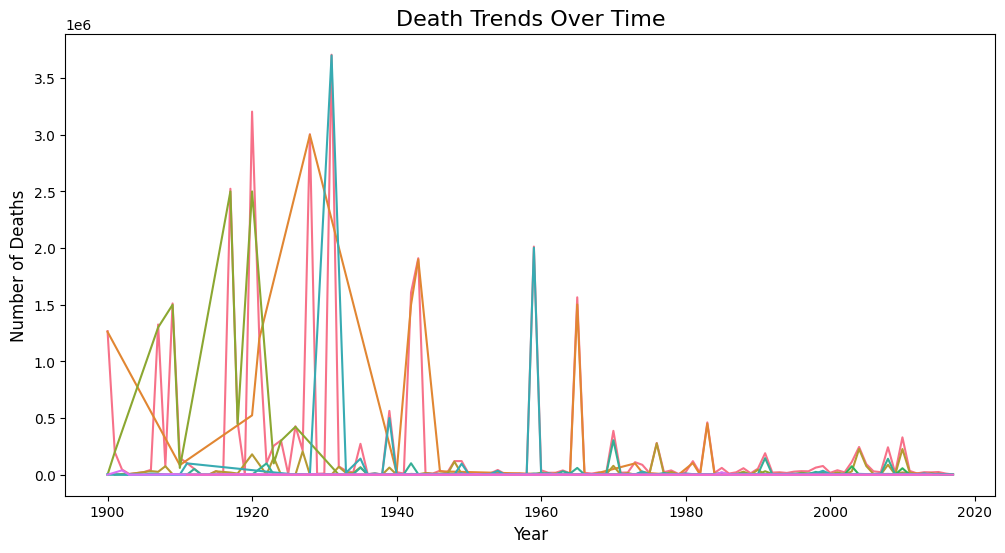

In [8]:
# Death trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='Deaths', hue='Entity', legend=None)
plt.title("Death Trends Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Deaths", fontsize=12)
plt.show()


In [9]:
# Step 3: Preprocessing

data.fillna(0, inplace=True)

# Encode 'Entity' column
label_encoder = LabelEncoder()
data['Entity'] = label_encoder.fit_transform(data['Entity'])

# Show unique categories
print("\nUnique disaster types and their encodings:")
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Unique disaster types and their encodings:
{'All natural disasters': 0, 'Drought': 1, 'Earthquake': 2, 'Epidemic': 3, 'Extreme temperature': 4, 'Extreme weather': 5, 'Flood': 6, 'Landslide': 7, 'Mass movement (dry)': 8, 'Volcanic activity': 9, 'Wildfire': 10}


In [10]:
# Features and target variable
X = data[['Entity', 'Year']]
y = data['Deaths']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
import numpy as np

# Log transformation of target variable
data['Deaths'] = data['Deaths'].apply(lambda x: np.log1p(x))

# Redo preprocessing and training
X = data[['Entity', 'Year']]
y = data['Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate MSE with transformed data
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error after log transformation: {mse:.2f}")
\
y_pred_original_scale = np.expm1(y_pred)


Mean Squared Error after log transformation: 4.33


In [24]:
import pickle

# Save the trained model
with open('linear_regression_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the LabelEncoder
with open('label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

print("Model and encoder saved successfully.")


Model and encoder saved successfully.


In [28]:
import gradio as gr
import numpy as np
import pickle


with open('linear_regression_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('label_encoder.pkl', 'rb') as encoder_file:
    label_encoder = pickle.load(encoder_file)

def preprocess_input(entity, year):
    # Encode the disaster type (Entity) using LabelEncoder
    entity_encoded = label_encoder.transform([entity])[0]
    # Return the data in the same format that the model expects
    return np.array([[entity_encoded, year]])

def predict_deaths(entity, year):
    # Preprocess input data
    input_data = preprocess_input(entity, year)

    # Predict using the trained model
    prediction = model.predict(input_data)

    # Inverse log transformation (to get the original scale of the target variable)
    prediction_original_scale = np.expm1(prediction[0])


    prediction_formatted = round(prediction_original_scale, 2)

    return prediction_formatted

# Gradio interface
iface = gr.Interface(
    fn=predict_deaths,
    inputs=[
        gr.Dropdown(choices=list(label_encoder.classes_), label="Disaster Type"),
        gr.Number(label="Year")
    ],
    outputs="number",
    title="Death Prediction from Disaster Data",
    description="Input the disaster type and year to predict the number of deaths."
)

# Launch the interface
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ea0bfa9561895341a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
